How do we connect theoretical detectability limit with the heuristic we use to get logistic regression parameters?

The # of edges between comms vs within communities in Y_ij can be used to connect it to theoretical detectability limit?
We know the theoretical limit of the PPM, so can we do tests to match it and use that as a proxy for lfr nets?

Detectability limit of normalized Laplacian matrix generated by PPM is mu* = 1- 1/sqrt(<k>), and mu = n * p_out/<k>

Use SBM nets, Laplacian eigenmaps, see how different the Y_ijs and eventually the elem centric sim changes with respect to increasing mixing in SBMs

In [1]:
# let's get the machinery going

import numpy as np
from scipy import sparse
import pandas as pd
#import os
#import networkx as nx
#import gensim
#import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.linear_model import LogisticRegression 
import faiss
import fast_hdbscan
import embcom

#import lfr
#import embcom
#import csv
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
#from scripts.clustering_methods import clustering_method_values

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
import numpy as np
import belief_propagation
import infomap

from graph_tool.all import Graph,minimize_blockmodel_dl

import graph_tool.all as gt
import numpy as np
import pandas as pd
from scipy import sparse, stats
from scipy.sparse.csgraph import connected_components


In [2]:
# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

In [3]:
def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dotsim",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances

# Only place where GPU is used, need to handle its closing. 
def find_knn(target, emb, num_neighbors, metric="dotsim", device=None): 
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    elif metric == "euclidean":
        index = faiss.IndexFlatL2(emb.shape[1])
    elif metric == "manhattan":
        index = faiss.IndexFlatL1(emb.shape[1])
    elif metric == "cosine":
        index = faiss.IndexFlatIP(emb.shape[1])
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    elif metric=="mahalanobis":
        # THis mathematical trick works, but it needs some reworking in target.astype to
        # give right results.
        # map the vectors back to a space where they follow a unit Gaussian
        xc = emb - emb.mean(0)
        cov = np.dot(xc.T, xc) / xc.shape[0]
        L = np.linalg.cholesky(cov)
        mahalanobis_transform = np.linalg.inv(L)
        emb = np.dot(emb, mahalanobis_transform.T)
        index = faiss.IndexFlatL2(emb.shape[1])
    else:
        raise ValueError("Invalid metric specified.")
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            elif metric == "euclidean":
                index = faiss.IndexFlatL2(emb.shape[1])
            elif metric == "manhattan":
                index = faiss.IndexFlatL1(emb.shape[1])
            elif metric == "cosine":
                index = faiss.IndexFlatIP(emb.shape[1])
                emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            else:
                raise ValueError("Invalid metric specified.")
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
        
    index.reset()
    return indices, distances

In [4]:
import numba

def louvain(Z, w1, b0, num_neighbors=10, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()
    
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
               Z=Vt,
               num_neighbors=num_neighbors,
               rho=b0/w1,
               node_size=node_size,
               epochs=iteration,
               device=device,
                )
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None,epochs=50): # This involves distance metrics (cosine similarity, atm)
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,epochs=100):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id]))

            for cprime in clist:
                if c == cprime: 
                    continue
                dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                        - rho * node_size[node_id] * Nc[cprime]) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids
 

### Get PPM network and generate embeddings using laplacian eigenmap


In [5]:
# Generating PPM code

# n = 10000 # 100000
# K = 64
# cave = 10
# mu = 0.4
# #mu = np.round(np.linspace(0.05, 1, 20), 2)

output_file = ""


def generate_network(Cave, mixing_rate, N, q):
    memberships = np.sort(np.arange(N) % q)

    q = int(np.max(memberships) + 1)
    N = len(memberships)
    U = sparse.csr_matrix((np.ones(N), (np.arange(N), memberships)), shape=(N, q))

    Cout = np.maximum(1, mixing_rate * Cave)
    Cin = q * Cave - (q - 1) * Cout
    pout = Cout / N
    pin = Cin / N

    Nk = np.array(U.sum(axis=0)).reshape(-1)

    P = np.ones((q, q)) * pout + np.eye(q) * (pin - pout)
    probs = np.diag(Nk) @ P @ np.diag(Nk)
    gt_params = {
        "b": memberships,
        "probs": probs,
        "micro_degs": False,
        "in_degs": np.ones_like(memberships) * Cave,
        "out_degs": np.ones_like(memberships) * Cave,
    }

    # Generate the network until the degree sequence
    # satisfied the thresholds
    while True:
        g = gt.generate_sbm(**gt_params)

        A = gt.adjacency(g).T

        A.data = np.ones_like(A.data)
        # check if the graph is connected
        if connected_components(A)[0] == 1:
            break
        break
    return A, memberships, pd.DataFrame({"community_id": memberships})



#A, memberships = generate_network(cave, mu, n, K)


# sparse.save_npz(output_file, A)
# node_ids = np.arange(A.shape[0]).astype(int)
# pd.DataFrame({"node_id": node_ids, "membership": memberships}).to_csv(
#     output_node_file, index=False
# )

In [6]:
n = int(1e4)
K = 50
cave = 50
mu_vals = np.round(np.linspace(0.05, 1, 20), 2)
mu=0.7
A, memberships, community_table = generate_network(cave, mu, n, K)

model = embcom.embeddings.LaplacianEigenMap()
model.fit(A)
emb = model.transform(dim=64)


How to see how different the Y_ijs are, how the edges between communities and within communities change?


In [7]:
# Evaluate the clustering
#def clustering_method_values(net, community_table, emb, score_keys, device_name):



# Normalize the vector of each node to have unit length. This normalization improves clustering.
X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
#X = emb.copy()
# Clustering

#def proposed_method_labels(emb,device_name):

rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=100, device = "cuda:0")
cneg = np.random.choice(emb.shape[0], len(cpos))
vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

# create a Y_ij matrix, where if Y_ij =
# = 1, i,j in same community
# = 0, i,j don't belong to same community
# We create Y_ij with and without negative sampling?

In [8]:
## Getting info about between and withing community edges of our k nn sampling

comlist = []
for i,j in zip(rpos, cpos):
    if i<j:
        comlist.append((i,j))
    else:
        comlist.append((j,i))

neglist=[]
for i,j in zip(rpos, cneg):
    if i<j:
        neglist.append((i,j))
    else:
        neglist.append((j,i))        

Y_edges = (set(comlist) - set(neglist))

within_community_edge = 0
between_community_edge = 0

for i in Y_edges:
    if memberships[i[0]] == memberships[i[1]]:
        within_community_edge+=1
    else:
        between_community_edge+=1

In [10]:
within_community_edge/(within_community_edge + between_community_edge)

0.9967201191472588

In [11]:
model = LogisticRegression()
model.fit(
    np.concatenate([vpos, vneg]).reshape((-1, 1)),
    np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
        )
w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
proposed_method_labels = louvain(emb, w1, b0, device =  "cuda:0")

In [12]:
calc_esim(community_table["community_id"], proposed_method_labels)     

0.9298770526682364

In [17]:
from time import perf_counter

def get_results(
                num_neighbors = 100,
                n = int(1e4),
                K = 50,
                cave = 50,
               ):

    
    mu_vals = np.round(np.linspace(0.7, 0.9, 21), 2)    
    
    run = 1
    data = []
    for mu in mu_vals:
        t_start = perf_counter()
        
        A, memberships, community_table = generate_network(cave, mu, n, K)
    
        
        model = embcom.embeddings.LaplacianEigenMap()
        model.fit(A)
        emb = model.transform(dim=64)
            
        
        # Normalize the vector of each node to have unit length. This normalization improves clustering.
        X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
        #X = emb.copy()
        # Clustering
        
        #def proposed_method_labels(emb,device_name):
        
        rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=num_neighbors, device = "cuda:0")
        cneg = np.random.choice(emb.shape[0], len(cpos))
        vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)
        
        ## Getting info about between and withing community edges of our k nn sampling
        
        comlist = []
        for i,j in zip(rpos, cpos):
            if i<j:
                comlist.append((i,j))
            else:
                comlist.append((j,i))
        
        neglist=[]
        for i,j in zip(rpos, cneg):
            if i<j:
                neglist.append((i,j))
            else:
                neglist.append((j,i))        
        #TODO: Check sums
        
        Y_edges = (set(comlist) - set(neglist))
        
        within_community_edge = 0
        between_community_edge = 0
        
        for i in Y_edges:
            if memberships[i[0]] == memberships[i[1]]:
                within_community_edge+=1
            else:
                between_community_edge+=1
        
        model = LogisticRegression()
        model.fit(
            np.concatenate([vpos, vneg]).reshape((-1, 1)),
            np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
                )
        w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
        proposed_method_labels = louvain(emb, w1, b0, device =  "cuda:0")
        
        esim = calc_esim(community_table["community_id"], proposed_method_labels) 

        row = (run, mu, num_neighbors, within_community_edge, between_community_edge,between_community_edge/(within_community_edge + between_community_edge), esim, n , K, cave)
        data.append(row)
        print(f"Mu: {mu} took {round(perf_counter()-t_start,2)} seconds")
    

    
    columns = ['run','mu', 'num_neighbors', 'within_community_edge', 'between_community_edge', 'ratio', 'esim', 'n', 'K', 'cave']

    # Convert data to a list of dictionaries
    data_dict = [
        dict(zip(columns, row))
        for row in data
    ]
    
    # Create DataFrame
    df = pd.DataFrame(data_dict)
   
    return df

In [23]:
# Okay we have all the parts, so now we want to get:
# a csv file or a df with Run #, mu value, k_nearest_neighbors_sampled, within_comm_edges, between_comm_edges, esim

df_300 = get_results(num_neighbors = 300)

Mu: 0.7 took 15.4 seconds
Mu: 0.71 took 17.2 seconds
Mu: 0.72 took 16.76 seconds
Mu: 0.73 took 17.12 seconds
Mu: 0.74 took 18.2 seconds
Mu: 0.75 took 18.03 seconds
Mu: 0.76 took 17.6 seconds
Mu: 0.77 took 17.85 seconds
Mu: 0.78 took 17.88 seconds
Mu: 0.79 took 17.93 seconds
Mu: 0.8 took 18.96 seconds
Mu: 0.81 took 19.18 seconds
Mu: 0.82 took 20.19 seconds
Mu: 0.83 took 20.2 seconds
Mu: 0.84 took 23.28 seconds
Mu: 0.85 took 28.45 seconds
Mu: 0.86 took 36.22 seconds
Mu: 0.87 took 37.89 seconds
Mu: 0.88 took 44.01 seconds
Mu: 0.89 took 40.15 seconds
Mu: 0.9 took 47.57 seconds


In [ ]:
df_500 = get_results(num_neighbors = 500)
df_400 = get_results(num_neighbors = 400)
df_200 = get_results(num_neighbors = 200)

Mu: 0.7 took 23.7 seconds
Mu: 0.71 took 25.4 seconds
Mu: 0.72 took 26.37 seconds
Mu: 0.73 took 26.23 seconds
Mu: 0.74 took 27.05 seconds
Mu: 0.75 took 26.69 seconds


In [ ]:
df = deepcopy(df_500)

# Calculate x and y values
x = df['mu']
y = df['esim']

# Create the plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot esim vs between_community_edge/within_community_edge
ax.plot(x, y, marker='o', linestyle='-', label='esim vs mu')

vertical_line_x = 1 - (1/np.sqrt(50))
ax.axvline(x=vertical_line_x, color='r', linestyle='--', label='1 - (1/sqrt(<k>))')

for i, txt in enumerate(np.round(df['between_community_edge'] / df['within_community_edge'], 3)):
    ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('mu')
ax.set_ylabel('esim')
plt.title("Esim vs mu, overlaid with ratio of edges between communities/within communities")
ax.legend()

plt.show()

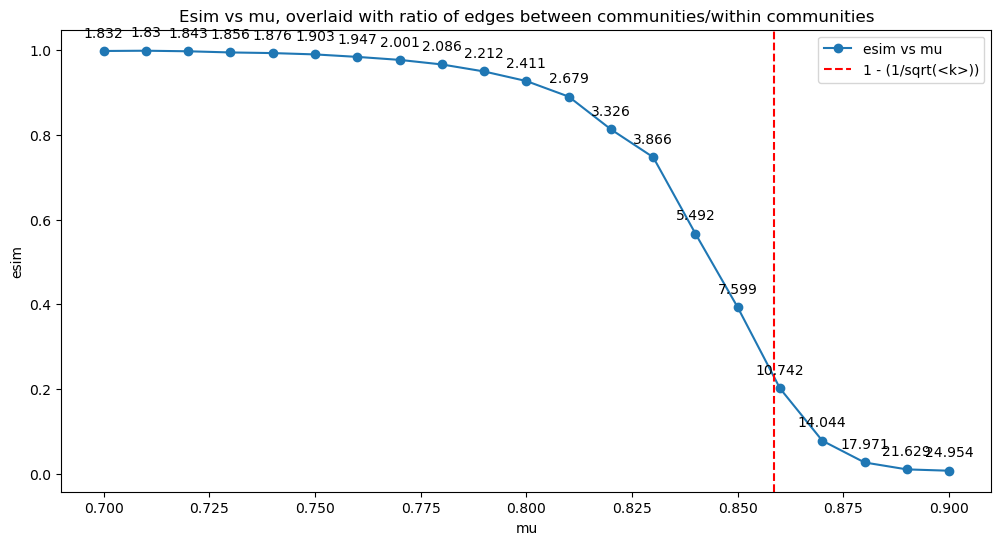

In [ ]:
df = deepcopy(df_400)

# Calculate x and y values
x = df['mu']
y = df['esim']

# Create the plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot esim vs between_community_edge/within_community_edge
ax.plot(x, y, marker='o', linestyle='-', label='esim vs mu')

vertical_line_x = 1 - (1/np.sqrt(50))
ax.axvline(x=vertical_line_x, color='r', linestyle='--', label='1 - (1/sqrt(<k>))')

for i, txt in enumerate(np.round(df['between_community_edge'] / df['within_community_edge'], 3)):
    ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('mu')
ax.set_ylabel('esim')
plt.title("Esim vs mu, overlaid with ratio of edges between communities/within communities")
ax.legend()

plt.show()

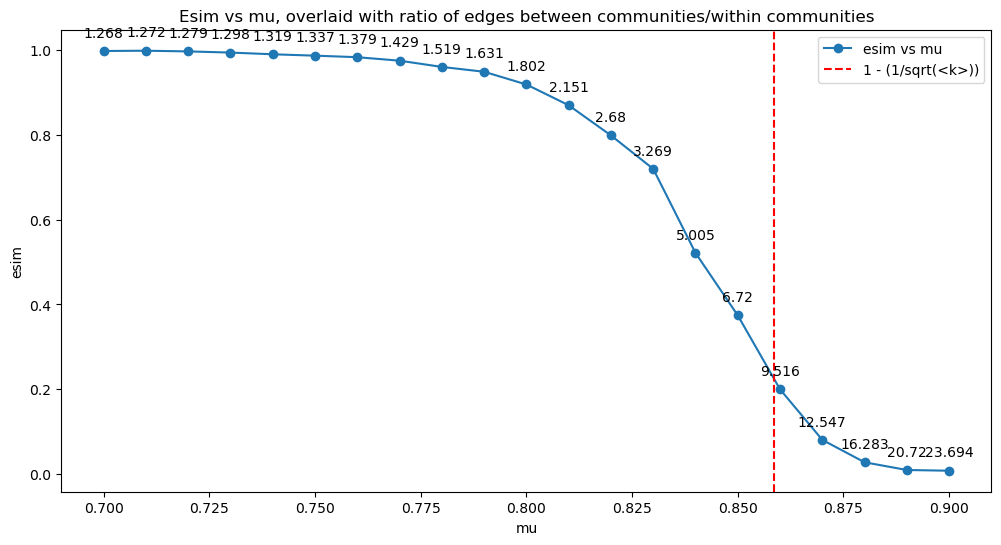

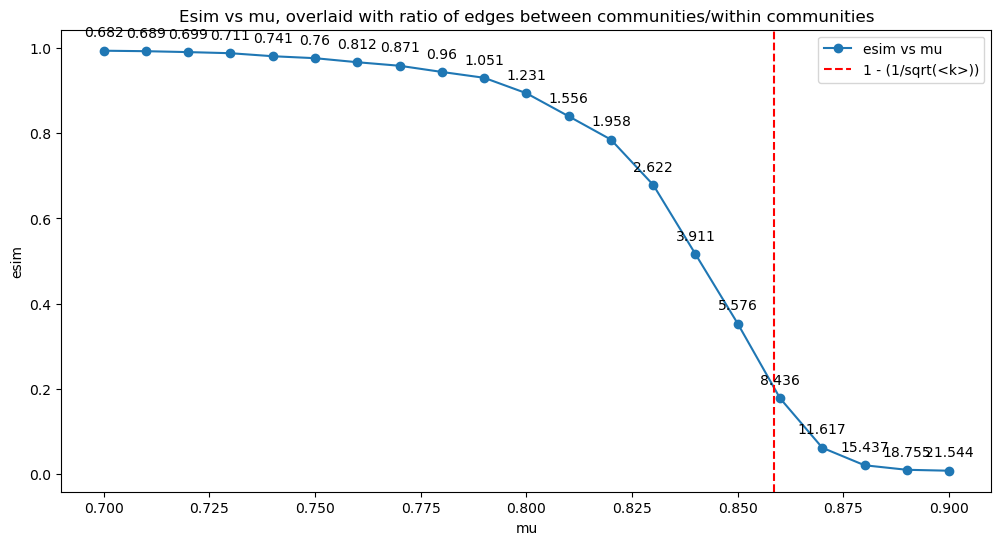

In [24]:
df = deepcopy(df_300)

# Calculate x and y values
x = df['mu']
y = df['esim']

# Create the plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot esim vs between_community_edge/within_community_edge
ax.plot(x, y, marker='o', linestyle='-', label='esim vs mu')

vertical_line_x = 1 - (1/np.sqrt(50))
ax.axvline(x=vertical_line_x, color='r', linestyle='--', label='1 - (1/sqrt(<k>))')

for i, txt in enumerate(np.round(df['between_community_edge'] / df['within_community_edge'], 3)):
    ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('mu')
ax.set_ylabel('esim')
plt.title("Esim vs mu, overlaid with ratio of edges between communities/within communities")
ax.legend()

plt.show()

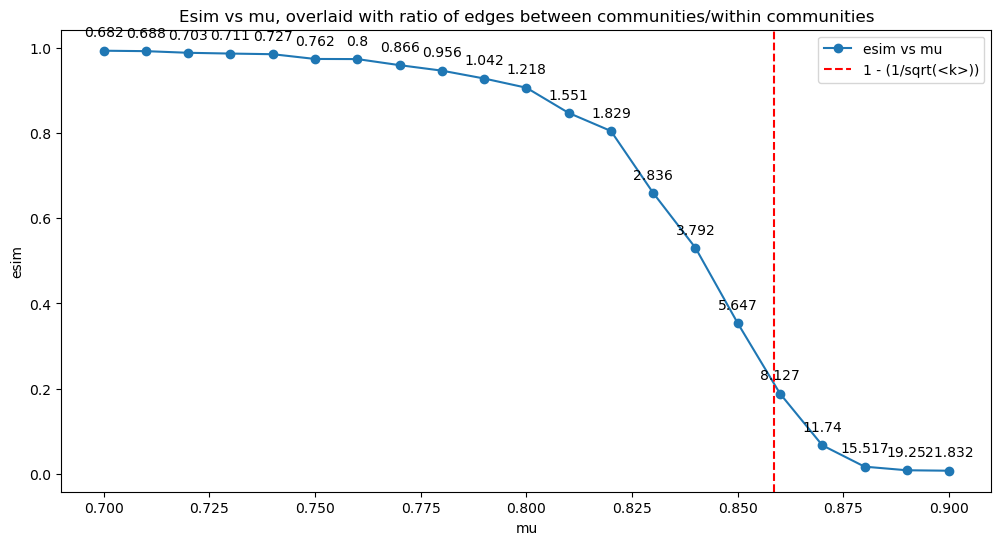

In [ ]:
# Calculate x and y values
df = deepcopy(df_200)
x = df['mu']
y = df['esim']

# Create the plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot esim vs between_community_edge/within_community_edge
ax.plot(x, y, marker='o', linestyle='-', label='esim vs mu')

vertical_line_x = 1 - (1/np.sqrt(50))
ax.axvline(x=vertical_line_x, color='r', linestyle='--', label='1 - (1/sqrt(<k>))')

for i, txt in enumerate(np.round(df['between_community_edge'] / df['within_community_edge'], 3)):
    ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('mu')
ax.set_ylabel('esim')
plt.title("Esim vs mu, overlaid with ratio of edges between communities/within communities")
ax.legend()

plt.show()

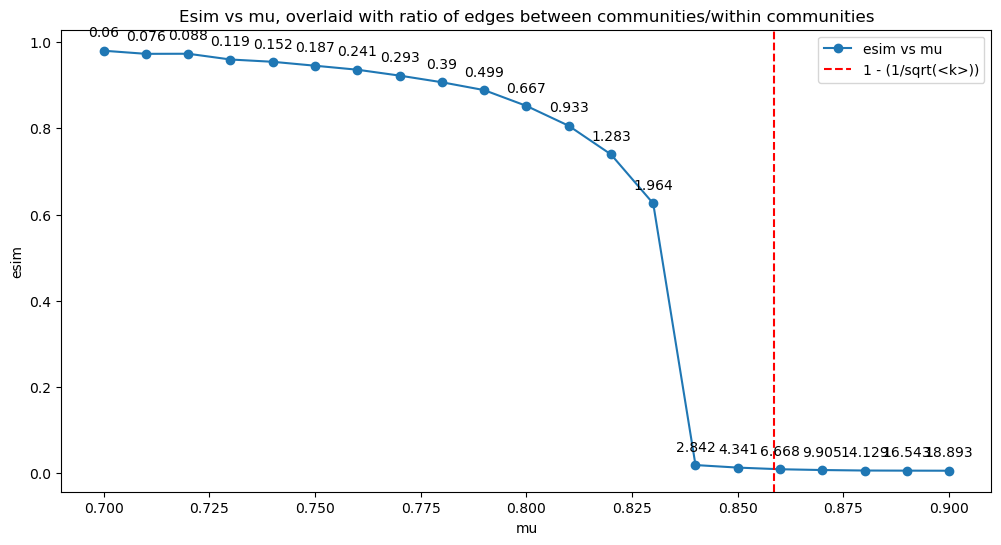

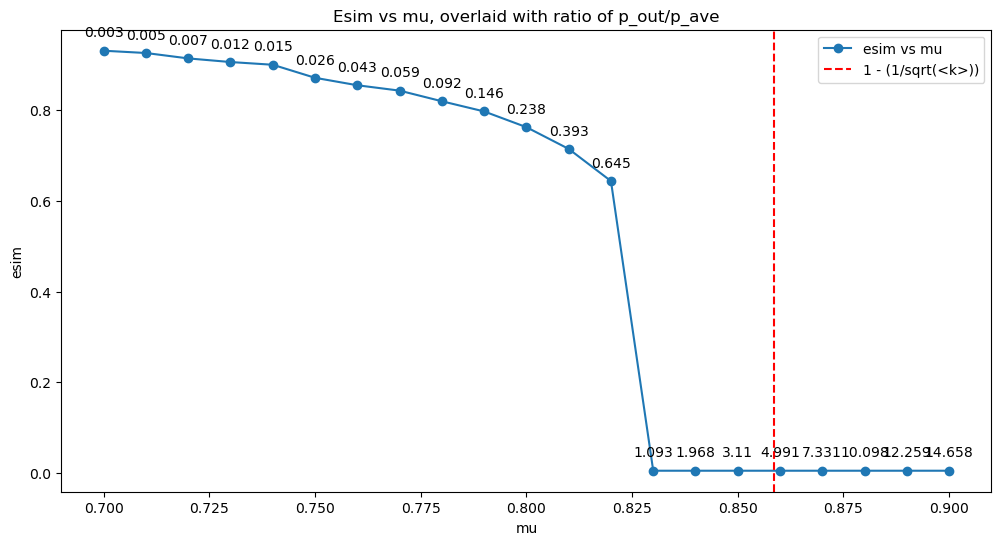

In [22]:
# Calculate x and y values
df = deepcopy(df_100)
x = df['mu']
y = df['esim']

# Create the plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot esim vs between_community_edge/within_community_edge
ax.plot(x, y, marker='o', linestyle='-', label='esim vs mu')

vertical_line_x = 1 - (1/np.sqrt(50))
ax.axvline(x=vertical_line_x, color='r', linestyle='--', label='1 - (1/sqrt(<k>))')

for i, txt in enumerate(np.round(df['between_community_edge'] / df['within_community_edge'], 3)):
    ax.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('mu')
ax.set_ylabel('esim')
plt.title("Esim vs mu, overlaid with ratio of p_out/p_ave")
ax.legend()

plt.show()

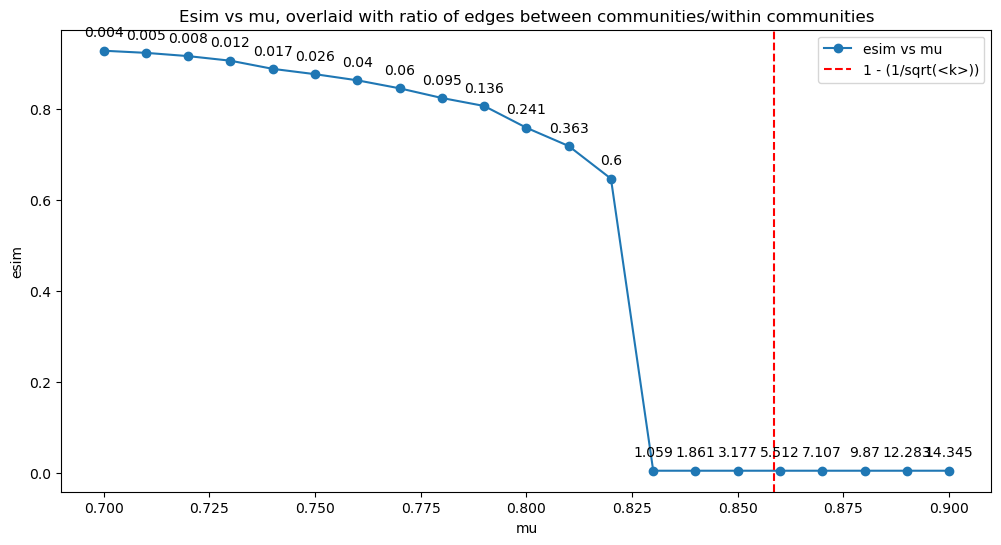

It jumps from suddenly at 0.6 to 1.059, if we increase the size of the network or if we change the number of neighbors, does this jump become less abrupt?

In [61]:
np.round(np.linspace(0.7, .9, 21), 2)

array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ])

In [ ]:
# See how parameters n, k and b/w ratio affect detectability. Can we get them to match detectability limi  1 - 1/sqrt(k)

In [ ]:
# Try using emb vs X, does it make it better? If yes, then we should definitely potts

In [ ]:
# Tomorrow test new potts model like clustering

In [ ]:
df_100.to_csv('df_100.csv')  
df_200.to_csv('df_200.csv')  
df_300.to_csv('df_300.csv')  
df_400.to_csv('df_400.csv')  
df_500.to_csv('df_500.csv')  
